In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from PIL import Image

csoupdata = pd.read_csv("./carsoupdotcom_07012017_17068entried_final.csv",sep=",",encoding='utf-8',\
                        usecols=[3,4,6,8,9])
                        #usenames=['localid','site','car_id','car_description',\
                        #'car_make','car_model','car_trim','car_year','car_category',\
                        #'car_mileage','car_price','car_extColor','car_transmission',\
                        #'car_driveTrain','car_vendor_city','car_vendor_state','car_vendor_zip',\
                        #'car_detail_link','car_img_link','car_engine'])
                        
csoupdata.head()

,car_make,car_model,car_year,car_mileage,car_price
carsoupdotcom,Toyota,Corolla-LE,2015,23036,13298
carsoupdotcom,Jeep,Wrangler-Unlimted-Sahara,2012,73619,26995
carsoupdotcom,Honda,Civic-LX,2014,27784,14097
carsoupdotcom,Jeep,Grand-Cherokee-Limited,2014,36636,27899
carsoupdotcom,Hyundai,Santa-Fe-Sport-24L,2013,48568,18981


In [3]:
# Creating a new dataframe with selected entries.  The selected data will have the a minimun
# number of entries (defined by THRESH) in the combination of car_make,car_model, and car_year
# This data will be used to apply the Bayesian Regression Model

# this df will hold the selected data
mincnt_selected_cardata = pd.DataFrame()
cmm_byyear_list = []

# NOTE: THRESHHOLD MAX IS CLOSE TO 108
THRESH = 40 

#downselecting based on car_make counts
selected_car_make_all_df = csoupdata.groupby('car_make').filter(lambda x: len(x) > THRESH)
selected_car_make_uniq = selected_car_make_all_df.car_make.unique()

#downselecting based on car_model counts
for each_cmake in selected_car_make_uniq:
    selected_car_make_df = selected_car_make_all_df[(selected_car_make_all_df['car_make'] == each_cmake) & \
                                            (selected_car_make_all_df['car_price'] > 0) & \
                                            (selected_car_make_all_df['car_mileage'] > 0)]  
  
    #downselecting based on car_model counts
    selected_car_model_all_df = selected_car_make_df.groupby('car_model').filter(lambda x: len(x) > THRESH)
    selected_car_model_uniq = selected_car_model_all_df.car_model.unique()

    #downselecting based on car_year counts
    for each_cmodel in selected_car_model_uniq:
        selected_car_model_df = selected_car_model_all_df[(selected_car_model_all_df['car_model'] == each_cmodel)]
        selected_car_year_df = selected_car_model_df.groupby('car_year').filter(lambda x: len(x) > THRESH)
        cy_cnt = selected_car_year_df.shape[0]
        if  cy_cnt> 0: 
            mincnt_selected_cardata = pd.concat([mincnt_selected_cardata,selected_car_year_df])
          
        
        #gathering counts per make, per model, per year     
        for each_cyear in selected_car_year_df.car_year.unique():
            cy_cnt = selected_car_year_df[selected_car_year_df.car_year == each_cyear].shape[0]
            cmm_byyear_list.append([each_cmake + " " + each_cmodel, each_cyear, cy_cnt])
            #print( cmm_byyear_list)
            
mincnt_selected_cardata_yearcnt = pd.DataFrame(cmm_byyear_list ,columns = ["car_make_model","car_year","car_year_cnt"])

mincnt_selected_cardata_yearcnt.head()

,car_make_model,car_year,car_year_cnt
0,Jeep Grand-Cherokee-Limited,2014,59
1,Honda Civic-LX,2014,80
2,Honda CR-V-LX,2014,44
3,Honda CR-V-EX-L,2014,48
4,Hyundai Santa-Fe-Sport-24L,2014,51


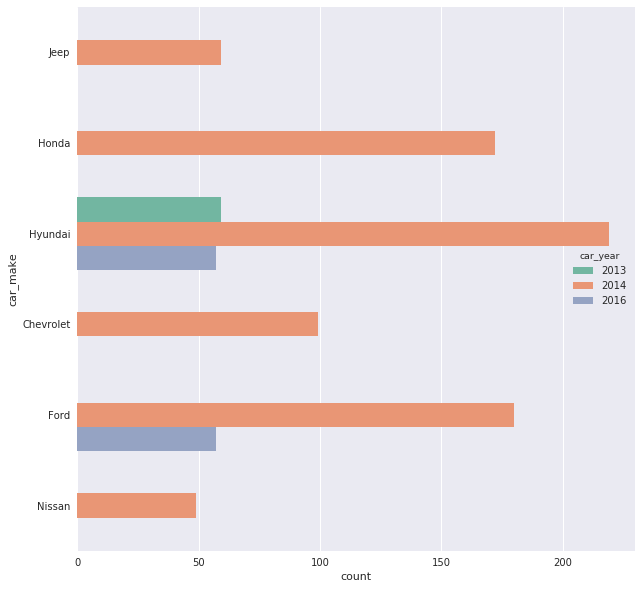

In [17]:
# EDA Additional
sns.set(style="darkgrid")
plt.figure(figsize=(10,10))
#plt.title("Car_Make (per car_mode and per car_year) Counts")
#fig,ax = plt.subplots(figsize=(15,15),ncols=1, nrows=2,sharex=True)
#sns.countplot(y='car_make',hue='car_model',data = mincnt_selected_cardata,ax=ax[0],palette="Set2")
#sns.countplot(y='car_make',hue='car_year',data = mincnt_selected_cardata,ax=ax[1],palette="Set2")
sns.countplot(y='car_make',hue='car_year',data = mincnt_selected_cardata,palette="Set2")


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

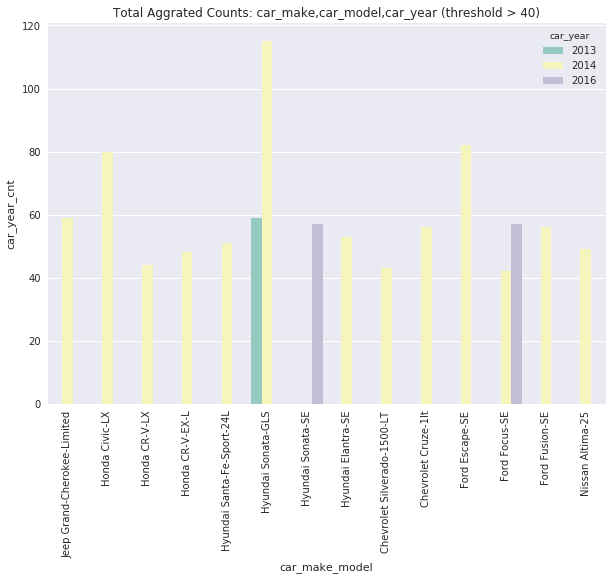

In [20]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="car_make_model", y="car_year_cnt", hue="car_year", data=mincnt_selected_cardata_yearcnt,palette="Set3");
plt.title("Total Aggrated Counts: car_make,car_model,car_year (threshold > 40)")
plt.xticks(rotation=90)